In [1]:
import SimpleITK as sitk
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from IPython.display import clear_output
import pprint
import os, sys
import pandas_profiling
import sys
import json
from scipy import ndimage
import nibabel as nib 
from pathlib import Path
sys.path.insert(0, str(Path(r'C:\Users\parkm\Desktop\github\analysis_nifti_for_deeplearning\src\registration_metric.py').resolve().parent.parent))
from src.eda_nifti import *
from src.registration_metric import *

In [2]:
nifti_anal =NiftiAnalysis()

In [3]:
task1_nifti_files_list = nifti_anal.recursive_find_all_files(r'C:\Users\parkm\Desktop\github\analysis_nifti_for_deeplearning\data\task1', '.nii.gz')

In [4]:
raw_path = r'C:\Users\parkm\Desktop\github\analysis_nifti_for_deeplearning\data\task1\rawdata\sub-strokecase0001\ses-0001\sub-strokecase0001_ses-0001_dwi.nii.gz'

In [5]:
mask_path = r'C:\Users\parkm\Desktop\github\analysis_nifti_for_deeplearning\data\task1\derivatives\sub-strokecase0001\ses-0001\sub-strokecase0001_ses-0001_msk.nii.gz'

# 1. 원본 단면 확인

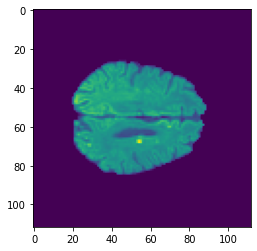

In [6]:
raw_nii = nib.load(raw_path)
raw_nii_array = raw_nii.get_fdata()
raw_nii_array.shape
plt.imshow(raw_nii_array[:,:,49])

# 2. 원본 + n4 correction 확인

In [7]:
input = sitk.ReadImage(raw_path)
image = sitk.Cast(input, sitk.sitkFloat32)
# print(type(image))
correctedImg = sitk.N4BiasFieldCorrection(image)
sitk.WriteImage(correctedImg, 'test.nii.gz') # outfile is just string variable or path

In [8]:
nii = nib.load('test.nii.gz')
nii_array = nii.get_fdata()
nii_array.shape

(112, 112, 73)

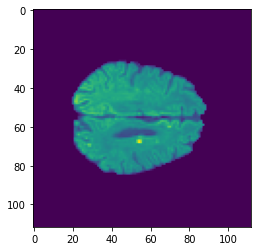

In [9]:
plt.imshow(nii_array[:,:,49])

# 3. 원본에서 라벨 마스크 아웃 + n4 correction
- antspy로 진행하면 antsimage로 작업하고 바로 저장하면되는데, 리눅스 환경 x, 대충 몇개만 돌려서 확인해보는 용도

In [10]:
raw_nii = nib.load(raw_path)
raw_nii_array = raw_nii.get_fdata()
raw_affine = raw_nii.affine

In [11]:
mask_nii = nib.load(mask_path)

In [12]:
mask_nii_array = mask_nii.get_fdata()

In [13]:
raw_nii_array.shape

(112, 112, 73)

In [14]:
mask_nii_array.shape

(112, 112, 73)

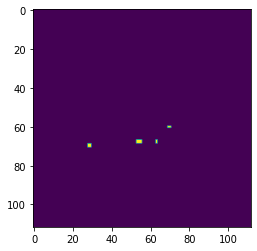

In [15]:
plt.imshow(mask_nii_array[:,:,49])

In [16]:
np.unique(np.ravel(raw_nii_array[:,:,49]))

array([  0.        ,  14.88266551,  21.6959706 , ..., 409.17928185,
       444.7661785 , 464.54226495])

In [17]:
np.unique(np.ravel(mask_nii_array[:,:,49]))

array([0., 1.])

In [18]:
raw_max_level_pixel = np.ravel(raw_nii_array).max()

In [19]:
mask_out_array = raw_nii_array + (mask_nii_array * raw_max_level_pixel*100)

In [20]:
mask_out_array[mask_out_array>raw_max_level_pixel+5] = 0

In [21]:
np.unique(np.ravel(mask_out_array[:,:,49]))

array([  0.        ,  14.88266551,  21.6959706 , ..., 367.03450323,
       372.52487946, 381.65965439])

In [22]:
np.unique(np.ravel(mask_out_array[:,:,49]))

array([  0.        ,  14.88266551,  21.6959706 , ..., 367.03450323,
       372.52487946, 381.65965439])

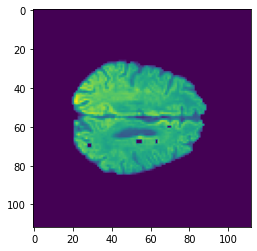

In [23]:
plt.imshow(mask_out_array[:,:,49])

In [24]:
img = nib.Nifti1Image(mask_out_array, raw_affine) 
img.to_filename('raw_mask_out.nii.gz')

In [25]:
input = sitk.ReadImage('raw_mask_out.nii.gz')
image = sitk.Cast(input, sitk.sitkFloat32)
# print(type(image))
correctedImg = sitk.N4BiasFieldCorrection(image)
sitk.WriteImage(correctedImg, 'n4_raw_mask_out.nii.gz')

In [26]:
## Segmentation된 부분만 확인

In [27]:
mask = np.any(mask_nii_array.astype(bool), axis=-1)

In [28]:
masked_img = raw_nii_array[:,:,49] * mask_nii_array[:,:,49]

In [29]:
masked_img

array([[ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.]])

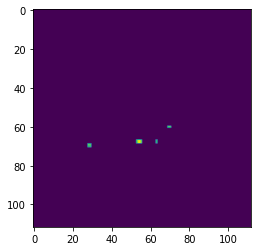

In [30]:
plt.imshow(masked_img)

In [31]:
np.unique(np.ravel(masked_img))

array([  0.        , 298.91764777, 307.15092553, 315.89303589,
       326.9588812 , 342.98902976, 351.45567605, 354.53617307,
       356.46563919, 364.20701337, 367.49679326, 390.30103546,
       409.17928185, 444.7661785 , 464.54226495])

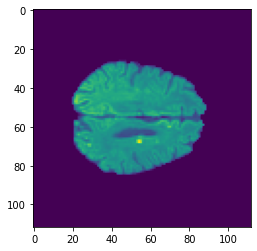

In [32]:
plt.imshow(raw_nii_array[:,:,49])

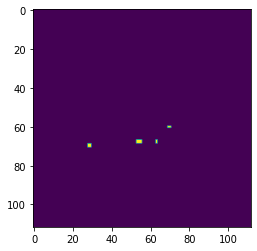

In [33]:
plt.imshow(mask_nii_array[:,:,49])

In [34]:
np.unique(np.ravel(mask_nii_array[:,:,49]))

array([0., 1.])

In [35]:
def n4_mask_out_n4_correction(input_raw_nifti_path: str, input_mask_nifti_path: str, n4_correction_result_save_path: str) ->np.array:
    
    raw_nii = nib.load(input_raw_nifti_path)
    raw_nii_array = raw_nii.get_fdata()
    raw_affine = raw_nii.affine
    raw_max_level_pixel = np.ravel(raw_nii_array).max()
    
    mask_nii = nib.load(input_mask_nifti_path)
    mask_nii_array = mask_nii.get_fdata()
    assert 1 in mask_nii_array or 0 in mask_nii_array, "incorrect values in mask array(mask array must be include only 0 or 1)" 
    
    
    mask_out_array = raw_nii_array * (1-mask_nii_array)
    
    img = nib.Nifti1Image(mask_out_array, raw_affine) 
    img.to_filename('temp_raw_mask_out.nii.gz')
    
    input = sitk.ReadImage('temp_raw_mask_out.nii.gz')
    image = sitk.Cast(input, sitk.sitkFloat32)

    # print(type(image))
    
    n4_correction_on_not_mask_region_only = sitk.N4BiasFieldCorrection(image)
    sitk.WriteImage(n4_correction_on_not_mask_region_only, os.path.join(n4_correction_result_save_path,'/n4_correction_on_not_mask_region_only.nii.gz'))
    
    return n4_correction_on_not_mask_region_only

In [36]:
def n4_mask_out_n4_correction_and_merge_with_lesion(input_raw_nifti_path: str, input_mask_nifti_path: str, n4_correction_result_save_path: str) ->np.array:
    
    raw_nii = nib.load(input_raw_nifti_path)
    raw_nii_array = raw_nii.get_fdata()
    raw_affine = raw_nii.affine
    raw_max_level_pixel = np.ravel(raw_nii_array).max()
    
    
    
    mask_nii = nib.load(input_mask_nifti_path)
    ## 효과가 있다면, 이 부분에서 voxel erosion 추가해서 라벨 근처 확장시켜주면 좋을 것 같습니다.
    mask_nii_array = mask_nii.get_fdata()
    assert 1 in mask_nii_array or 0 in mask_nii_array, "incorrect values in mask array(mask array must be include only 0 or 1)" 
    
    mask_legion_of_raw_data = raw_nii_array * mask_nii_array
    mask_out_array = raw_nii_array * (1-mask_nii_array)
    
    # 마스크 아웃 한 파일 저장
    img = nib.Nifti1Image(mask_out_array, raw_affine) 
    img.to_filename('temp_raw_mask_out.nii.gz')
    
    
    # 마스크 아웃 파일 불러와서 마스크 아웃된 부분만 n4 correction 수행
    input = sitk.ReadImage('temp_raw_mask_out.nii.gz')
    image = sitk.Cast(input, sitk.sitkFloat32)
    # print(type(image))
    correctedImg_without_legion = sitk.N4BiasFieldCorrection(image)
    
    
    
    n4_correction_on_not_mask_region_only = correctedImg_without_legion
    
    sitk.WriteImage(n4_correction_on_not_mask_region_only, 'correctedImg_without_legion.nii.gz')
    
    
    # 학습용으로 원래 마스크된 부분의 값들과 마스크 아웃해서 n4 correction된 내용 병합
    img_for_merge = nib.load('correctedImg_without_legion.nii.gz')
    img_for_merge = img_for_merge.get_fdata()
    
    merged_data = img_for_merge +  mask_legion_of_raw_data
    
    img = nib.Nifti1Image(mask_out_array, raw_affine) 
    img.to_filename(os.path.join(n4_correction_result_save_path,'temp_raw_mask_out.nii.gz'))
    
    
    
    
    return merged_data 

In [37]:
merged_data = n4_mask_out_n4_correction_and_merge_with_lesion(raw_path, mask_path, './')

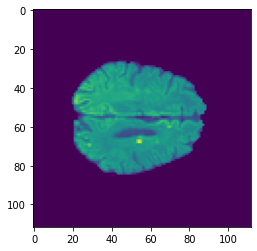

In [38]:
plt.imshow(merged_data[:,:,49])